In [1]:
import math, os, sys, re
import pandas as pd
import numpy as np
import numpy.ma as ma
import collections, itertools

# stats
from scipy.stats import (
    poisson, entropy, binom, multinomial
)

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import LogNorm
import seaborn as sns
plt.rcParams['figure.dpi'] = 300

import matplotlib.font_manager
font_dir = '/n/groups/marks/projects/CEPI/notebooks/ralph/myfonts/'
for font in matplotlib.font_manager.findSystemFonts(font_dir):
    matplotlib.font_manager.fontManager.addfont(font)
plt.rcParams['font.family'] = 'Helvetica'

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [126]:
def multinomial_test(AC, AN):
    """Perform a Multinomial LRT of the distribution of SNP across populations
    
    Parameters:
    -----------
        AC, AN: (NumPy matrices) allele counts and numbers data of dimensions
            (num_snps, num_populations) each.
            
    Returns:
    --------
        stats: test statistics of dimensions (num_snps,)
        
    """
    AN = ma.masked_equal(AN, 0)
    p0 = AN/AN.sum(1, keepdims=True)
    p1 = AC/AC.sum(1, keepdims=True)
    C = AC.sum(1)
    l0 = multinomial.logpmf(AC, n=C, p=p0)
    l1 = multinomial.logpmf(AC, n=C, p=p1)
    stats = -2 * (l0 - l1)
    
    return stats
    
def population_shannon_entropy(AF):
    """Compute the Shannon entropy of the population distribution of a SNP
    
    Parameters:
    -----------
        AF: (NumPy matrices) allele frequency data of dimensions
            (num_snps, num_populations).
            
    Returns:
    --------
        H: entropy of dimensions (num_snps,)
    """
    p = AF/AF.sum(1, keepdims=True)
    H = entropy(p, axis=1, base=p.shape[1])
    return H

def product_of_binomials_test(AC, AN):
    """Perform a product of independent Binomials likelihood ratio test (ProBiT)
    
    Parameters:
    -----------
        AC, AN: (NumPy matrices) allele counts and numbers data of dimensions
            (num_snps, num_populations) each.
            
    Returns:
    --------
        stats: test statistics of dimensions (num_snps,)
        
    """
    AN = ma.masked_equal(AN, 0)
    p0 = (AC.sum(1)/AN.sum(1))[:, np.newaxis]
    p1 = AC/AN
    
    l0 = binom.logpmf(AC, n=AN, p=p0)
    l1 = binom.logpmf(AC, n=AN, p=p1)
    stats = -2*(l0.sum(1) - l1.sum(1))
    
    return stats
    
class StructuredColumns:
    def __init__(self, col_list):
        self.col_list = col_list
        self.df = pd.DataFrame(col_list).set_index('key')
        self.fields = self.df.columns.tolist()
        self.keys = self.df.index.tolist()
        self.fields_str = '\n\t- '.join(self.fields)
        self.keys_str = '\n\t- '.join(self.keys)
    
    def __getitem__(self, tup):
        ret = self.df
        for f, t in zip(self.fields, tup):
            if not t is None:
                if isinstance(t, str):
                    ret = ret[ret[f]==t]
                elif isinstance(t, list):
                    ret = ret[ret[f].isin(t)]
        return ret.index.tolist()
    
    def __repr__(self):
        return f"fields (count: {len(self.fields)}):\n\t- {self.fields_str}\nkeys (count: {len(self.keys)}):\n\t- {self.keys_str}"

pop_cols =[{'data':data,
      'field': field,
      'pop': pop,
      'cohort': cohort,
      'key': data[0]+":"+'-'.join([field, pop, cohort])} 
       for field in ['AN', 'AC', 'AF', 'faf95', 'faf99']
      for cohort in ['all', 'controls']
     for data in ['genome', 'exome', 'both']
    for pop in pops[data]]

summary_cols =[{'data':data,
        'field': field,
        'summary': summary,
        'cohort': cohort,
        'key': data[0]+":"+'-'.join([field, summary, cohort])} 
       for cohort in ['all', 'controls']
       for field in ['AN', 'AC', 'AF', 'faf95', 'faf99']
      for summary in ['total', 'popmax']
     for data in ['genome', 'exome', 'both']]

pop_cols = StructuredColumns(pop_cols)
summary_cols = StructuredColumns(summary_cols)
    
def compute_filtering_AF(AC, AN, prob=0.95, max_iter=10):
    """Compute the filtering allele frequencies described in Whiffin et al. (2017)
    
    Whiffin et al. use R's uniroot function and increment by 1e-6 to find the maximum
    filtering AF with a 95% cumulative probability of observing at least as many as
    AC occurences of a variant in the data. 
    
    My implementation below is much faster, much more scalable (fully vectorized), and more 
    exact (no arbitrary incrementation), as it uses the Newton-Raphson root-finding method 
    and an analytically derived derivative.
    
    Parameters:
    -----------
        AC: (int or NumPy array of int) The allele counts observed in a genotype dataset.
            Array input should be of dimensions (num_snps,).
        AN: (int or NumPy array of int, same as AN) The allele numbers in the same dataset
            in which the allele counts were observed. AN should have the same type and
            dimensions as AC.
        max_iter: (int) The maximum number of iterations done in the Newton-Raphson
            optimization.
            
    Note: AC and AN can also be floats as long as the floats are whole numbers.
    
    Returns:
    --------
        AF: (float or NumPy array of float) The filtering allele frequencies described in 
            Whiffin et al. (2017). Default is 10.
    
    """
    
    assert AN.shape == AC.shape, "AN and AC must have the same dimensions"
    
    # initialize AF
    AF_0 = AC/AN
    
    for i in range(max_iter):
        # compute f and its derivative
        f = poisson.cdf(AC, mu=AF_0*AN) - prob
        dfdAF = -AN * poisson.pmf(AC, mu=AF_0*AN)
        
        # Newton-Raphson step
        AF_1 = AF_0 - f/dfdAF
        
        # break if all converged
        if np.isclose(AF_1, AF_0, rtol=1e-15, atol=1e-15).all():
            break
        else:
            AF_0 = AF_1
            
    AF_1[AC<1] = 0
    return AF_1

class gnomADDataset:
    def __init__(
        self,
        genome_path,
        exome_path,
    ):
        self.genome_path, self.exome_path = genome_path, exome_path
        self.genome = pd.read_table(genome_path, low_memory=False, na_values='.')
        self.exome = pd.read_table(exome_path, low_memory=False, na_values='.')
        self.genome = self.genome.loc[:, ~self.genome.columns.str.contains('raw')]
        self.exome = self.exome.loc[:, ~self.exome.columns.str.contains('raw')]
        
        
        # cleaning up and prepping for merge
        # populations
        self.d_to_data = {'g': 'genome', 'e':'exome', 'b':'both'}
        self.pops = {
            'genome':['eas', 'sas', 'amr', 'ami', 'nfe', 'fin', 'oth', 'mid', 'asj', 'afr'],
            'exome':['nfe', 'oth', 'eas', 'amr', 'afr', 'asj', 'sas', 'fin']
        }
        self.pops['both_isect'] = [p for p in self.pops['genome'] if p in self.pops['exome']]
        self.pops['both'] = list(set(self.pops['genome'] + self.pops['exome']))
        
        # instantiating custom StructureColumns objects to make column navigation easier
        # one is for population-specific columns, the other for summary-level columns
        pop_cols =[{'data':data,
              'field': field,
              'pop': pop,
              'cohort': cohort,
              'key': data[0]+":"+'-'.join([field, pop, cohort])} 
               for field in ['AN', 'AC', 'AF', 'faf95', 'faf99']
              for cohort in ['all', 'controls']
             for data in ['genome', 'exome', 'both']
            for pop in pops[data]]

        summary_cols =[{'data':data,
                'field': field,
                'summary': summary,
                'cohort': cohort,
                'key': data[0]+":"+'-'.join([field, summary, cohort])} 
               for cohort in ['all', 'controls']
               for field in ['AN', 'AC', 'AF', 'faf95', 'faf99']
              for summary in ['total', 'popmax']
             for data in ['genome', 'exome', 'both']]
        
        self.pop_cols = StructuredColumns(pop_cols)
        self.summary_cols = StructuredColumns(summary_cols)
        
        # cleaning up genomes columns
        genome_col_rename = (
            {f'{field}-{pop}': f"{field}-{pop}-all" for field in ['AN', 'AC', 'faf95', 'faf99'] for pop in pops['genome']}|
            {f'{field}-controls_and_biobanks-{pop}': f"{field}-{pop}-controls" for field in ['AN', 'AC'] for pop in pops['genome']}|
            {f'{field}': f'{field}-total-all' for field in ['AN', 'AC', 'faf95', 'faf99']}|
            {f'{field}-controls_and_biobanks': f'{field}-total-controls' for field in ['AN', 'AC', 'faf95', 'faf99']}|
            {f'{field}_popmax': f'{field}-popmax-all' for field in ['AN', 'AC', 'faf95', 'faf99']}
        )
        exome_col_rename = (
            {f'{field}_{pop}': f"{field}-{pop}-all" for field in ['AN', 'AC', 'faf95', 'faf99'] for pop in pops['exome']}|
            {f'controls_{field}_{pop}': f"{field}-{pop}-controls" for field in ['AN', 'AC'] for pop in pops['exome']}|
            {f'{field}': f'{field}-total-all' for field in ['AN', 'AC', 'faf95', 'faf99']}|
            {f'controls_{field}': f'{field}-total-controls' for field in ['AN', 'AC', 'faf95', 'faf99']}|
            {f'{field}_popmax': f'{field}-popmax-all' for field in ['AN', 'AC', 'faf95', 'faf99']}|
            {f'controls_{field}_popmax': f'{field}-popmax-controls' for field in ['AN', 'AC', 'faf95', 'faf99']}
        )
        self.genome = (self.genome.rename(columns = genome_col_rename)
                       .add_prefix('g:')
                       .rename(columns = {f'g:{col}': col for col in ['CHROM', 'POS', 'REF', 'ALT']}))
        
        self.exome = (self.exome.loc[:, ~self.exome.columns.str.contains('nfe_...|eas_...')]
                      .rename(columns=exome_col_rename).add_prefix('e:')
                     .rename(columns = {f'e:{col}': col for col in ['CHROM', 'POS', 'REF', 'ALT']}))
        
        # merging genomes and exomes
        self.both = self.genome.merge(self.exome, on=['CHROM', 'POS', 'REF', 'ALT'], how='outer', indicator=True)
        self.both._merge = self.both._merge.replace({'left_only': 'genomes', 'right_only':'exomes'})
        
        print('Combining exome and genome AN/AC columns ...')
        for b_col in (self.pop_cols[('both', ['AN', 'AC'], None, None)] + 
                      self.summary_cols[('both', ['AN', 'AC'], None, None)]):
            e_col = re.sub("b:", "e:", b_col, count=1)
            g_col = re.sub("b:", "g:", b_col, count=1)
            print(f"{b_col} <- {g_col} + {e_col}")
            self.both[b_col] = ((self.both[e_col].fillna(0) if e_col in self.both else 0) + 
                                (self.both[g_col].fillna(0) if g_col in self.both else 0))
        
        # to avoid DataFrame fragmentation
        self.both = self.both.copy()
        
        print('\nCombining allele frequencies ...')
        for af_col in (self.pop_cols[(None, 'AF', None, None)] + 
                      self.summary_cols[(None, 'AF', 'total', None)]):
            ac_col = re.sub("AF", "AC", af_col, count=1)
            an_col = re.sub("AF", "AN", af_col, count=1)
            print(f"{af_col} <- {ac_col} / {an_col}")
            self.both[af_col] = self.both[ac_col] / self.both[an_col]
            
        # to avoid DataFrame fragmentation
        self.both = self.both.copy()
        
        print('\nComputing filtering allele frequencies ...')
        # at the population level
        for faf_col in (self.summary_cols[(None, 'faf95', 'total', None)] + 
                        self.pop_cols[(None, 'faf95', None, None)]):
            ac_col = re.sub("faf95", "AC", faf_col, count=1)
            an_col = re.sub("faf95", "AN", faf_col, count=1)
            print(faf_col)
            self.both[faf_col] = compute_filtering_AF(self.both[ac_col].fillna(0)-1, self.both[an_col].fillna(0), max_iter=20)
        
        self.both = self.both.dropna(subset=['b:AF-total-all'], axis=0).reset_index()
        
        # to avoid DataFrame fragmentation
        self.both = self.both.copy()
        
        for faf_col in (self.summary_cols[(None, 'faf99', 'total', None)] + 
                        self.pop_cols[(None, 'faf99', None, None)]):
            ac_col = re.sub("faf99", "AC", faf_col, count=1)
            an_col = re.sub("faf99", "AN", faf_col, count=1)
            print(faf_col)
            self.both[faf_col] = compute_filtering_AF(self.both[ac_col].fillna(0)-1, self.both[an_col].fillna(0), prob=0.99, max_iter=20)
        
        # to avoid DataFrame fragmentation
        self.both = self.both.copy()
        
        print('\nComputing population maxima ...')
        for popmax_col in self.summary_cols[(None, ['AF', 'faf95', 'faf99'], 'popmax', None)]:
            print(popmax_col)
            args = re.search("(?P<data>[geb]):(?P<field>(?:AF|faf95|faf99))-popmax-(?P<cohort>(?:all|controls))", popmax_col)
            data, field, cohort = self.d_to_data[args.group('data')], args.group('field'), args.group('cohort')
            pop_df = self.both[self.pop_cols[(data, field, None, cohort)]]
            self.both[popmax_col] = pop_df.max(1)
            popargmax_col = f"{data[0]}:{field}-popargmax-{cohort}"
            self.both[popargmax_col] = pop_df.idxmax(1)
            
            ANpopargmax_col = f"{data[0]}:{field}-ANpopargmax-{cohort}"
            self.both[ANpopargmax_col] = self.both.apply(
                lambda row: row[re.sub(field, "AN", row[popargmax_col])] 
                if not pd.isna(row[popargmax_col]) else np.nan,
                axis='columns'
            )
            
            self.both[popargmax_col] = self.both[popargmax_col].str.extract("[geb]:.*?-(...)-.*")
        
        print('\nComputing Shannon entropy ...')
        non_zero_AC = (self.both['b:AC-total-all']>0)
        AF = self.both.loc[non_zero_AC, self.pop_cols[('both', 'AF', None, 'all')]].fillna(0)
        self.both.loc[non_zero_AC, 'entropy'] = population_shannon_entropy(AF.values)
        
        print('\nComputing product of Binomials test ...')
        AN = self.both.loc[non_zero_AC, self.pop_cols[('both', 'AN', None, 'all')]].values
        AC = self.both.loc[non_zero_AC, self.pop_cols[('both', 'AC', None, 'all')]].values
        self.both.loc[non_zero_AC, 'bin_test'] = product_of_binomials_test(AC, AN)
        
        print('\nComputing Shannon entropy ...')
        self.both.loc[non_zero_AC, 'mult_test'] = multinomial_test(AC, AN)

In [127]:
gnomad = gnomADDataset('data/gnomad/gnomad.genomes.annotations.tab', 'data/gnomad/gnomad.exomes.annotations.tab')

Combining exome and genome AN/AC columns ...
b:AN-afr-all <- g:AN-afr-all + e:AN-afr-all
b:AN-amr-all <- g:AN-amr-all + e:AN-amr-all
b:AN-asj-all <- g:AN-asj-all + e:AN-asj-all
b:AN-sas-all <- g:AN-sas-all + e:AN-sas-all
b:AN-ami-all <- g:AN-ami-all + e:AN-ami-all
b:AN-fin-all <- g:AN-fin-all + e:AN-fin-all
b:AN-eas-all <- g:AN-eas-all + e:AN-eas-all
b:AN-nfe-all <- g:AN-nfe-all + e:AN-nfe-all
b:AN-oth-all <- g:AN-oth-all + e:AN-oth-all
b:AN-mid-all <- g:AN-mid-all + e:AN-mid-all
b:AN-afr-controls <- g:AN-afr-controls + e:AN-afr-controls
b:AN-amr-controls <- g:AN-amr-controls + e:AN-amr-controls
b:AN-asj-controls <- g:AN-asj-controls + e:AN-asj-controls
b:AN-sas-controls <- g:AN-sas-controls + e:AN-sas-controls
b:AN-ami-controls <- g:AN-ami-controls + e:AN-ami-controls
b:AN-fin-controls <- g:AN-fin-controls + e:AN-fin-controls
b:AN-eas-controls <- g:AN-eas-controls + e:AN-eas-controls
b:AN-nfe-controls <- g:AN-nfe-controls + e:AN-nfe-controls
b:AN-oth-controls <- g:AN-oth-controls + e:

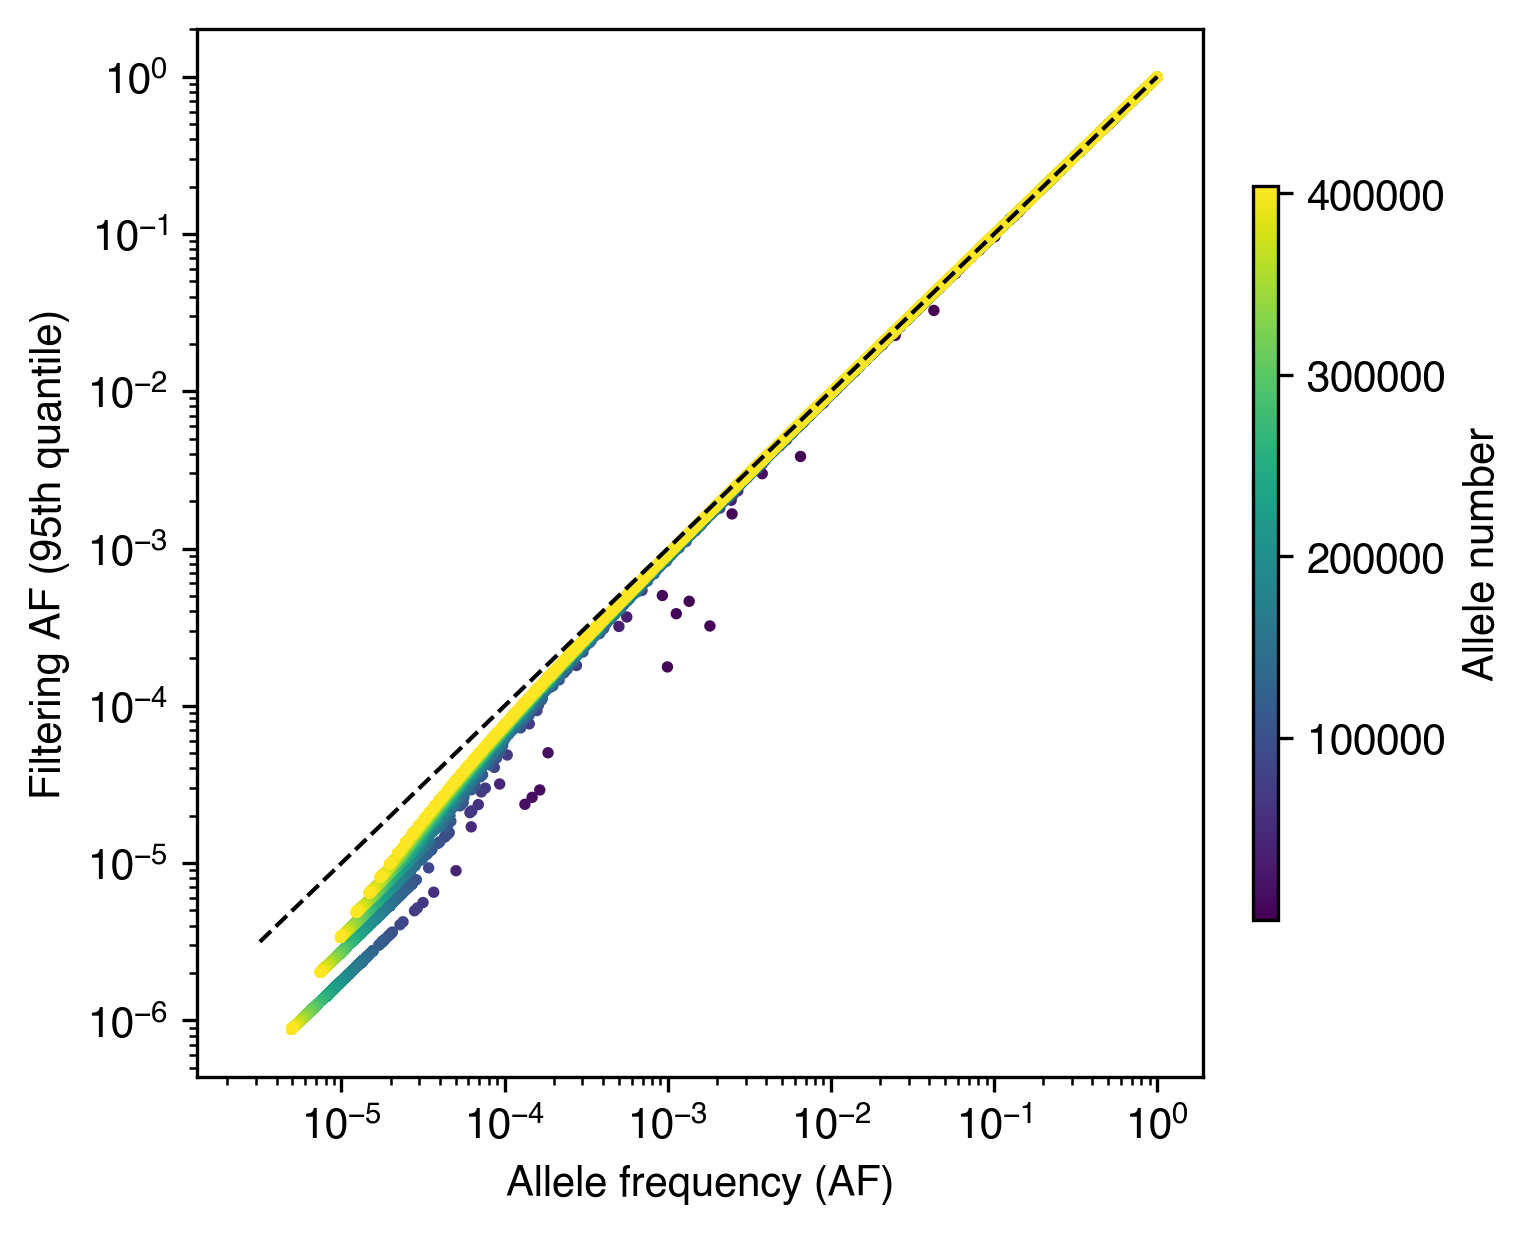

In [137]:
x = np.power(10.0, -np.arange(5.5, -0.5, -0.5))
fig, ax = plt.subplots(1,1, figsize=(5,4), constrained_layout=True)
idx = gnomad.both['b:AN-total-all'].argsort()
scatter = ax.scatter(gnomad.both['b:AF-total-all'][idx], gnomad.both['b:faf95-total-all'][idx], c= gnomad.both['b:AN-total-all'][idx], s=3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Allele frequency (AF)')
ax.set_ylabel(r'Filtering AF (95th quantile)')
plt.colorbar(scatter, ax=ax, shrink=0.7, label='Allele number', aspect=30)
ax.plot(x,x, color='k', ls='dashed', lw=1)

fig.savefig("af_v_faf.png");

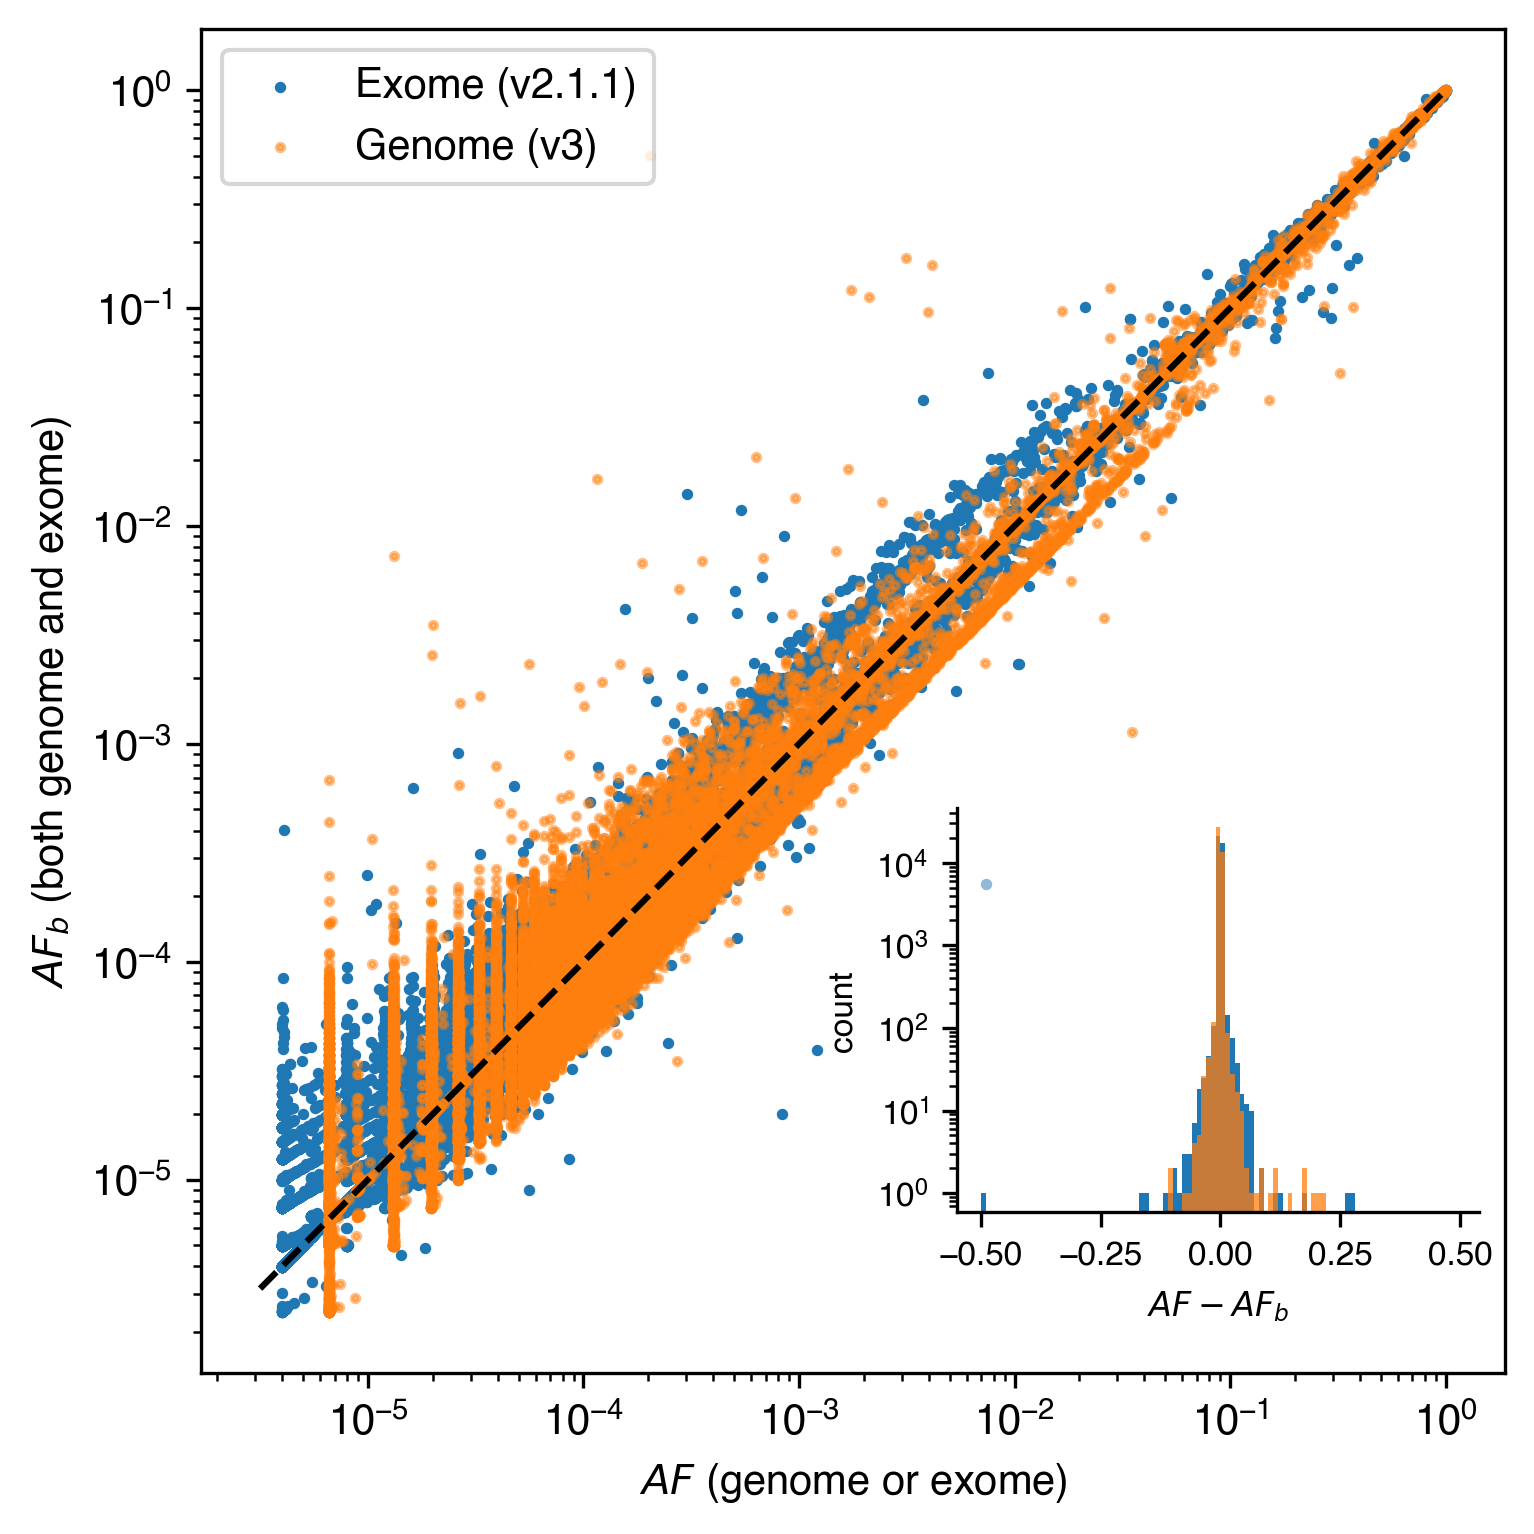

In [138]:
fig, ax = plt.subplots(1,1,figsize=(5,5), constrained_layout=True)
ax.scatter(gnomad.both['e:AF-total-all'].fillna(0), gnomad.both['b:AF-total-all'], s=3)
ax.scatter(gnomad.both['g:AF-total-all'].fillna(0), gnomad.both['b:AF-total-all'], s=3, alpha=0.5)
ax.plot(x,x, color='k', ls='dashed')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$AF$ (genome or exome)')
ax.set_ylabel(r'$AF_{b}$ (both genome and exome)')
ax.legend(['Exome (v2.1.1)', 'Genome (v3)'], loc='upper left')

inset_ax = ax.inset_axes([0.58, 0.12, 0.4, 0.3])
inset_ax.hist(gnomad.both['g:AF-total-all']- gnomad.both['b:AF-total-all'], bins=np.arange(-0.5, 0.5, 0.01));
inset_ax.hist(gnomad.both['e:AF-total-all']- gnomad.both['b:AF-total-all'], bins=np.arange(-0.5, 0.5, 0.01), alpha=0.75);
inset_ax.set_yscale('log')
inset_ax.tick_params(axis='both', which='both', labelsize=8)
inset_ax.set_xlabel(r'$AF-AF_{b}$', fontsize=8)
inset_ax.set_ylabel('count', fontsize=8)
inset_ax.spines['top'].set_visible(False)
inset_ax.spines['right'].set_visible(False)
inset_ax.patch.set_alpha(0.5)
fig.savefig("afeg_v_afb.png");

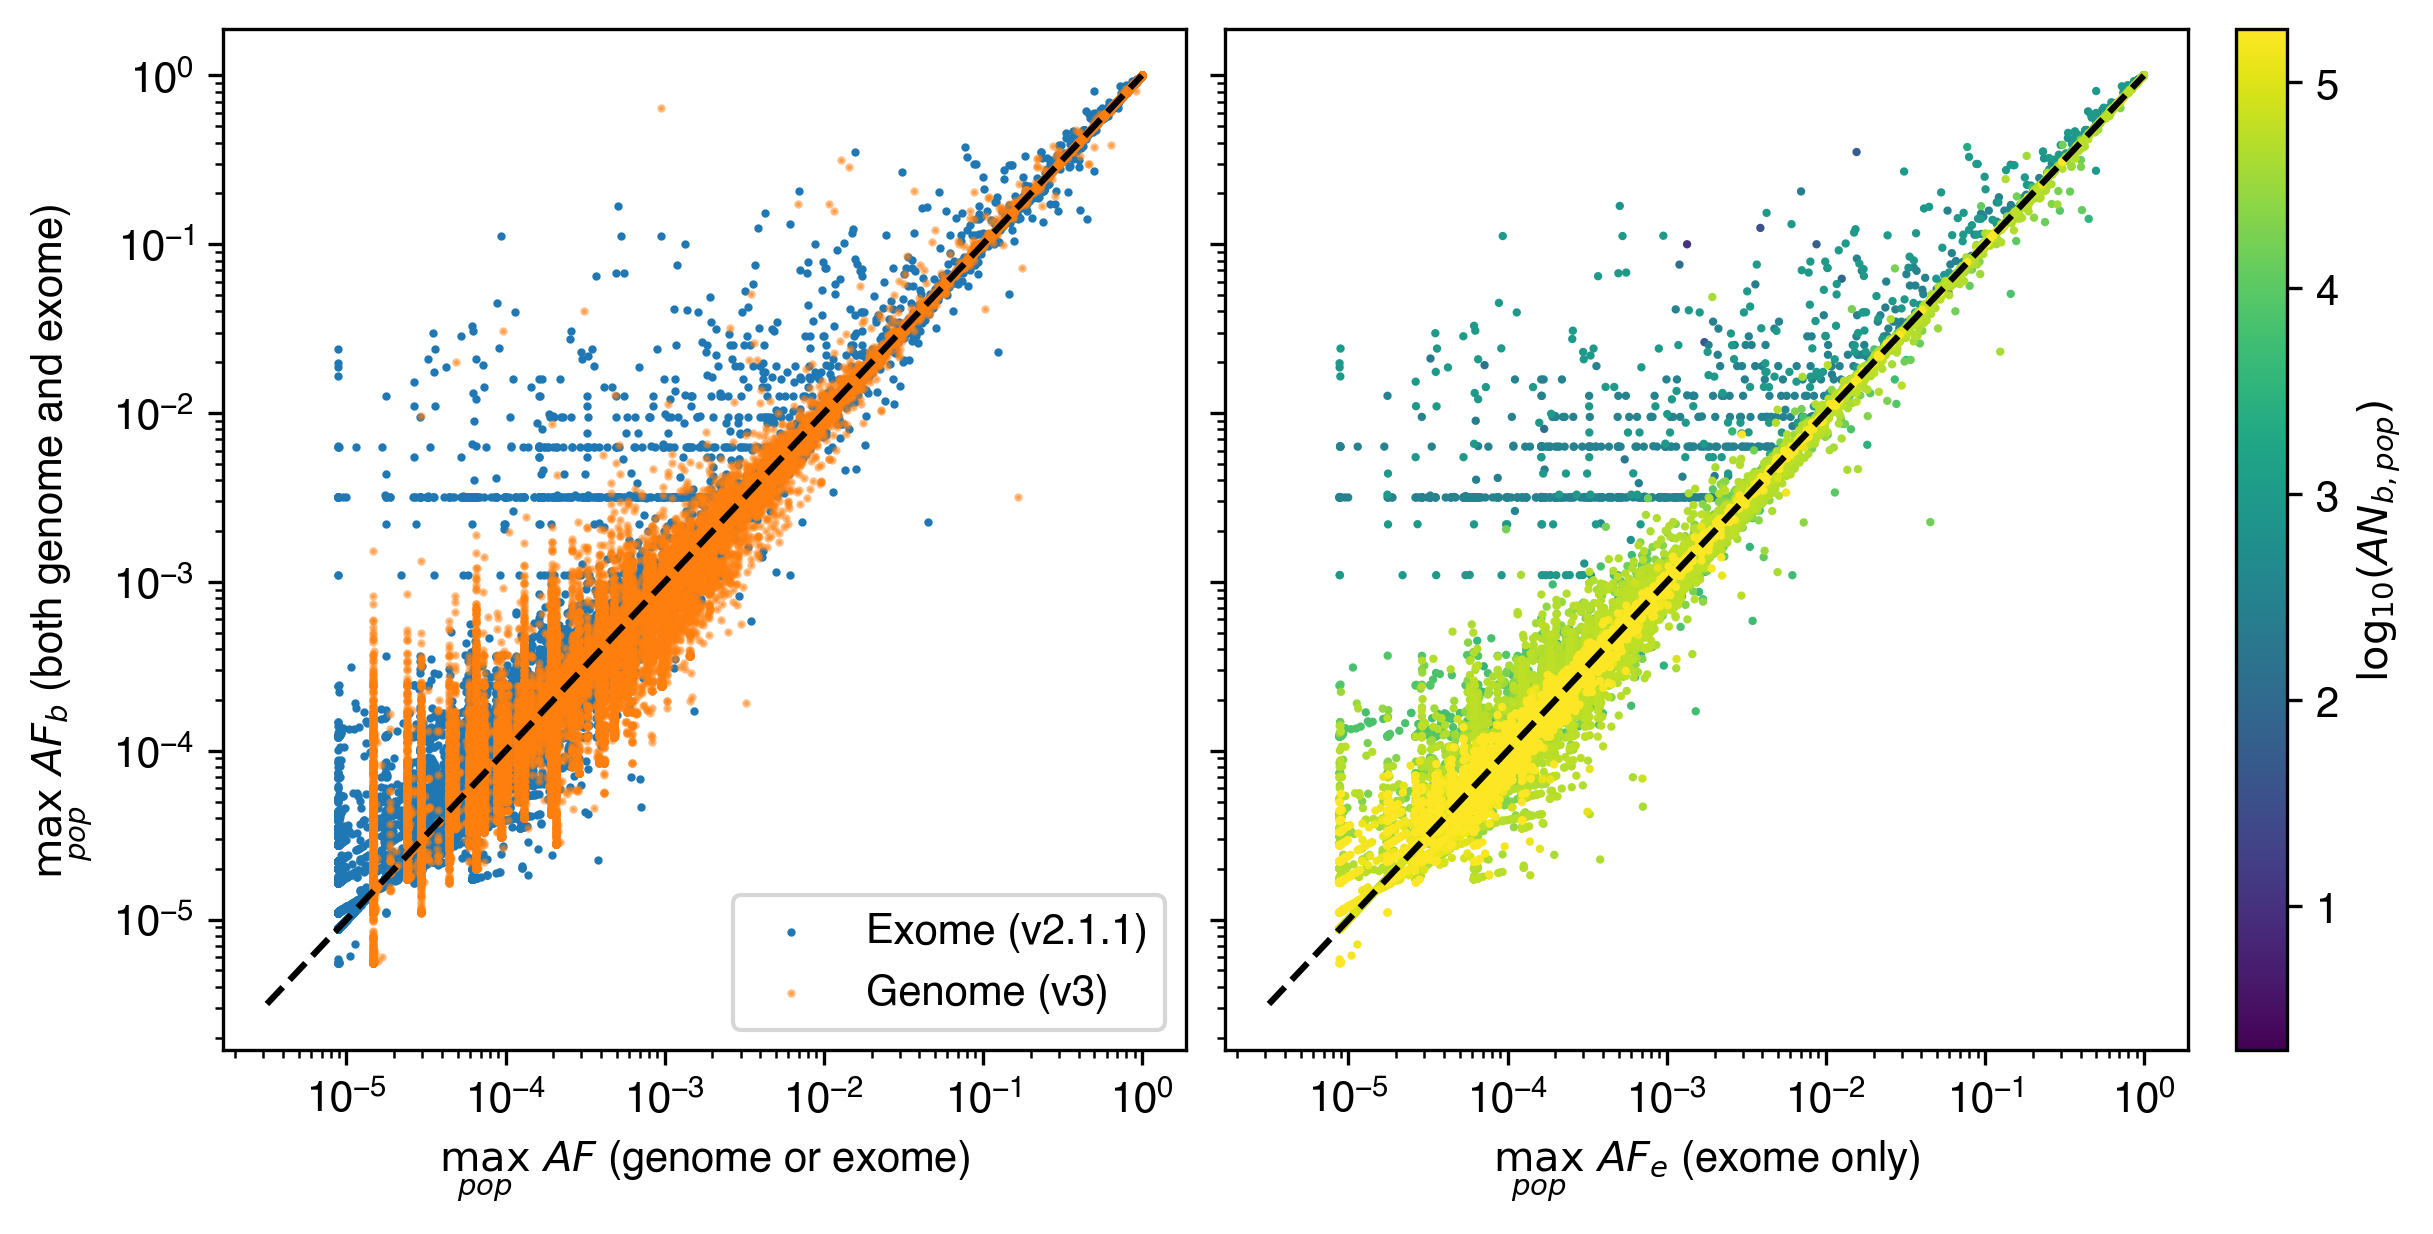

In [139]:
fig, axs = plt.subplots(1,2,figsize=(8,4), constrained_layout=True, sharey=True)
ax = axs[0]
ax.scatter(gnomad.both['e:AF-popmax-all'], gnomad.both['b:AF-popmax-all'], s=1)
ax.scatter(gnomad.both['g:AF-popmax-all'], gnomad.both['b:AF-popmax-all'], s=1, alpha=0.5)
ax.plot(x,x, color='k', ls='dashed')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\max_{pop}\ AF$ (genome or exome)')
ax.set_ylabel(r'$\max_{pop}\ AF_b$ (both genome and exome)')
ax.legend(['Exome (v2.1.1)', 'Genome (v3)'])

ax = axs[1]
idx = gnomad.both['b:AF-ANpopargmax-all'].argsort()
scatter = ax.scatter(gnomad.both['e:AF-popmax-all'][idx], 
                     gnomad.both['b:AF-popmax-all'][idx], 
                     s=1, c=np.log10(gnomad.both['b:AF-ANpopargmax-all'][idx]))
ax.plot(x,x, color='k', ls='dashed')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\max_{pop}\ AF_e$ (exome only)')
plt.colorbar(scatter, label=r'$\log_{10}(AN_{b, pop})$');

fig.savefig("af_vs_afb_popmax.png");

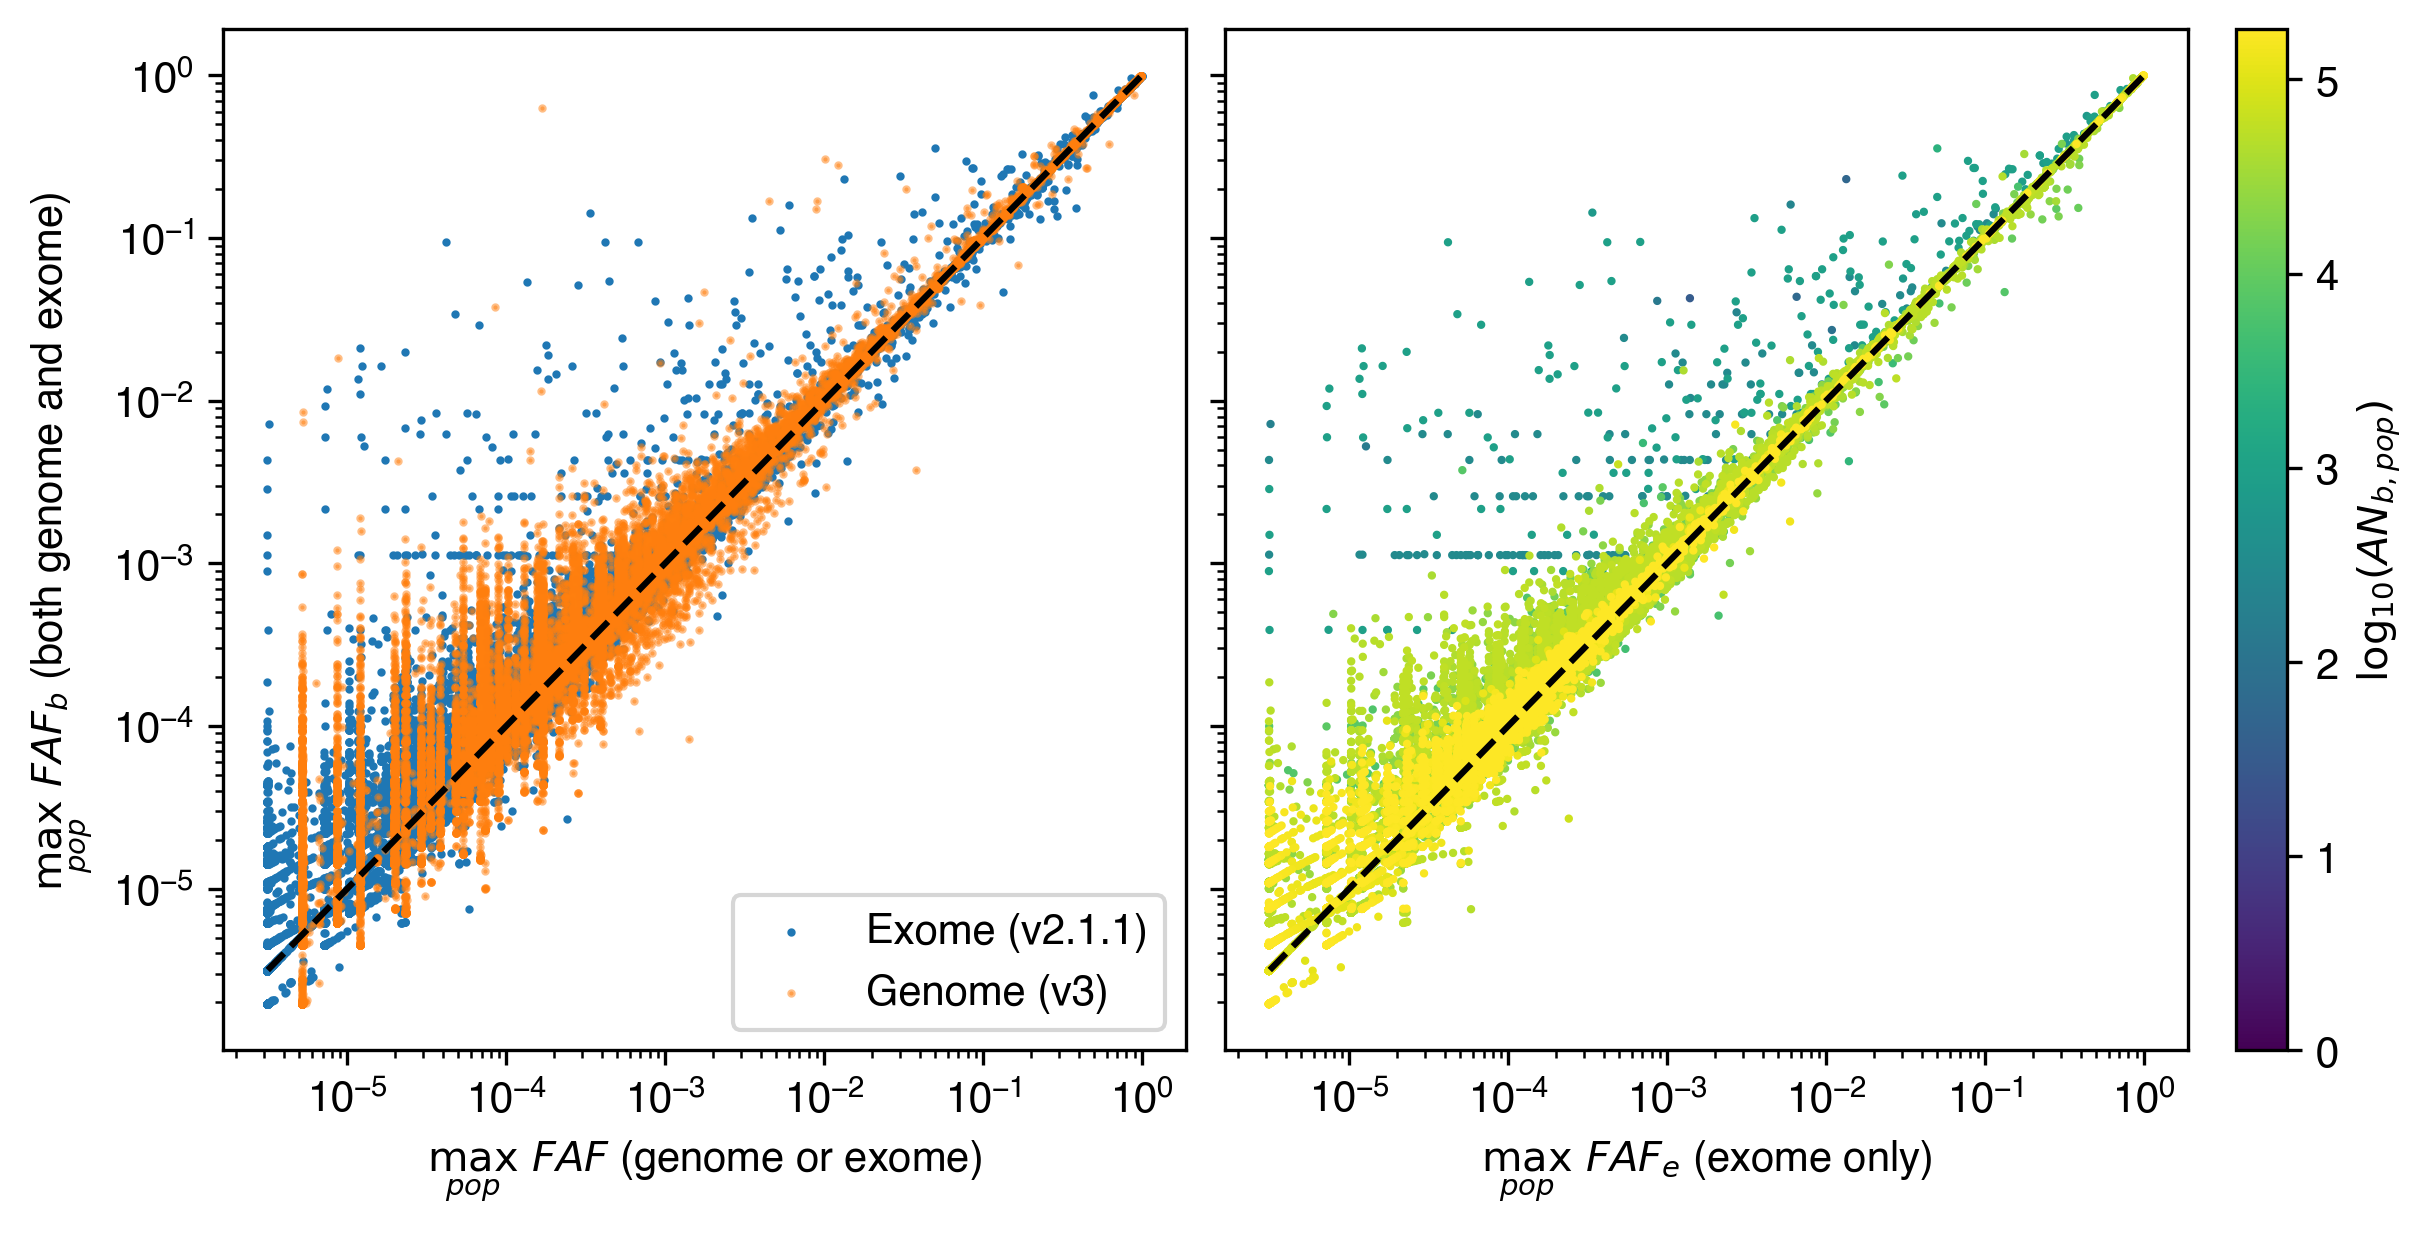

In [140]:
fig, axs = plt.subplots(1,2,figsize=(8,4), constrained_layout=True, sharey=True)
ax = axs[0]
ax.scatter(gnomad.both['e:faf95-popmax-all'], gnomad.both['b:faf95-popmax-all'], s=1)
ax.scatter(gnomad.both['g:faf95-popmax-all'], gnomad.both['b:faf95-popmax-all'], s=1, alpha=0.5)
ax.plot(x,x, color='k', ls='dashed')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\max_{pop}\ FAF$ (genome or exome)')
ax.set_ylabel(r'$\max_{pop}\ FAF_b$ (both genome and exome)')
ax.legend(['Exome (v2.1.1)', 'Genome (v3)'])

ax = axs[1]
idx = gnomad.both['b:faf95-ANpopargmax-all'].argsort()
scatter = ax.scatter(gnomad.both['e:faf95-popmax-all'][idx], 
                     gnomad.both['b:faf95-popmax-all'][idx], 
                     s=1, c=np.log10(gnomad.both['b:faf95-ANpopargmax-all'][idx]+1))
ax.plot(x,x, color='k', ls='dashed')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\max_{pop}\ FAF_e$ (exome only)')
plt.colorbar(scatter, label=r'$\log_{10}(AN_{b, pop})$');

fig.savefig("faf_vs_fafb_popmax.png");

/tmp/ipykernel_23723/230418555.py:14: RuntimeWarning: divide by zero encountered in true_divide
  min_entropy = lambda ac: (np.log10(ac/(ac-1)) + np.log10(ac-1)/ac)
/tmp/ipykernel_23723/230418555.py:14: RuntimeWarning: divide by zero encountered in log10
  min_entropy = lambda ac: (np.log10(ac/(ac-1)) + np.log10(ac-1)/ac)
/tmp/ipykernel_23723/230418555.py:14: RuntimeWarning: invalid value encountered in log10
  min_entropy = lambda ac: (np.log10(ac/(ac-1)) + np.log10(ac-1)/ac)
/tmp/ipykernel_23723/230418555.py:14: RuntimeWarning: invalid value encountered in add
  min_entropy = lambda ac: (np.log10(ac/(ac-1)) + np.log10(ac-1)/ac)
/tmp/ipykernel_23723/230418555.py:14: RuntimeWarning: divide by zero encountered in true_divide
  min_entropy = lambda ac: (np.log10(ac/(ac-1)) + np.log10(ac-1)/ac)
/tmp/ipykernel_23723/230418555.py:14: RuntimeWarning: divide by zero encountered in log10
  min_entropy = lambda ac: (np.log10(ac/(ac-1)) + np.log10(ac-1)/ac)
/tmp/ipykernel_23723/230418555.py:14: 

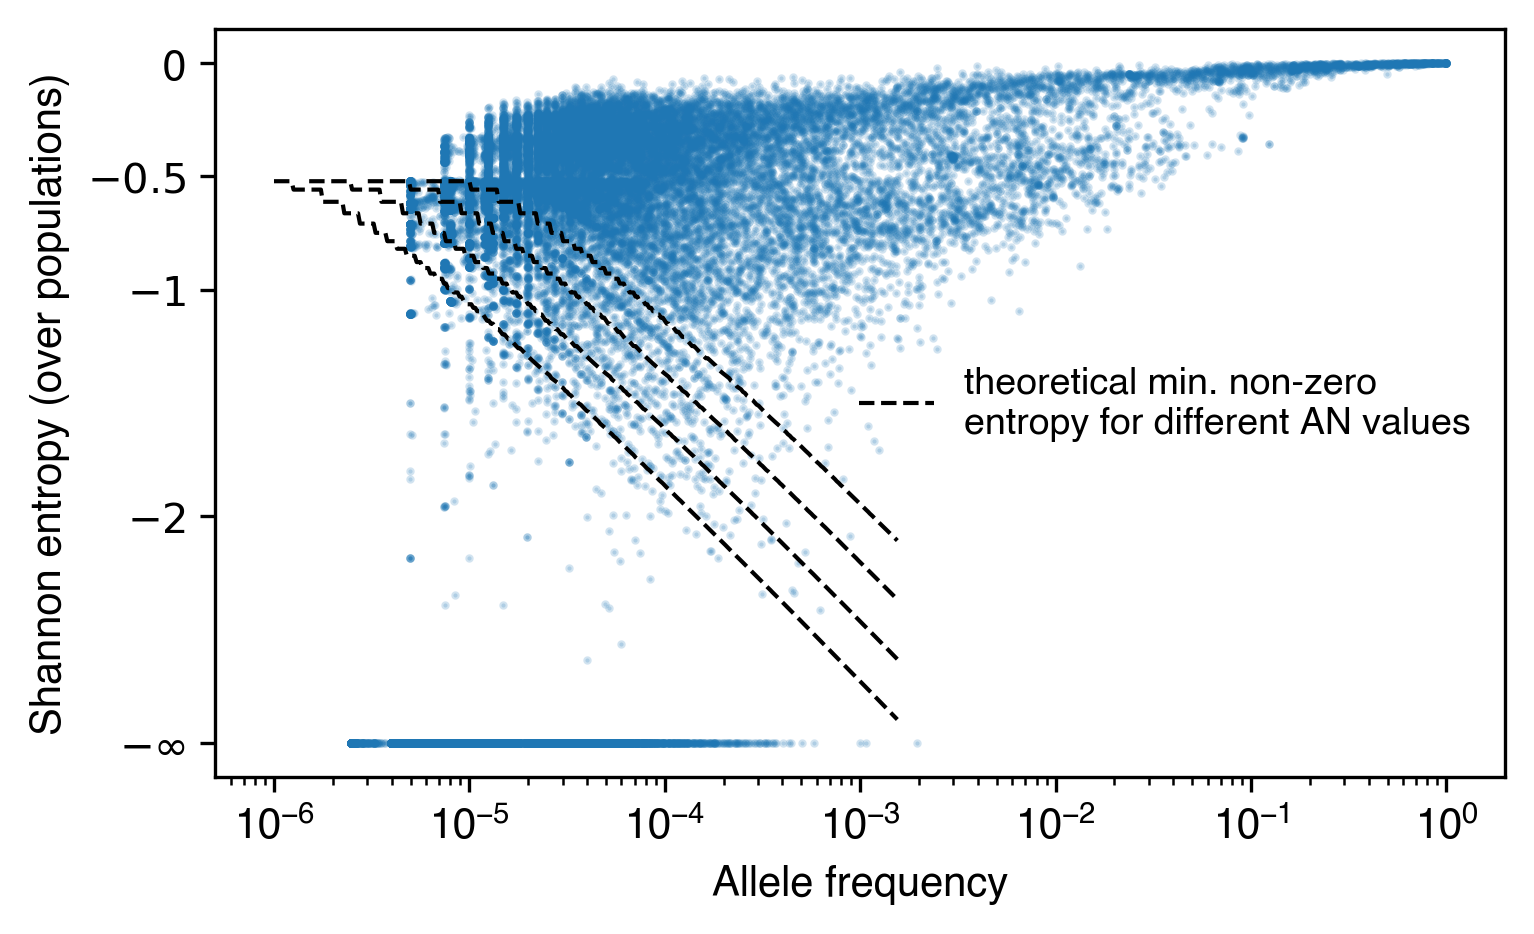

In [141]:
fig, ax = plt.subplots(1,1,figsize=(5,3), constrained_layout=True)

ax.scatter((gnomad.both['b:AF-total-all']), 
           np.log10(gnomad.both['entropy']+1e-3), 
           s=1, color='tab:blue', alpha=0.2)
ax.set_xscale('log')
ax.set_xlabel('Allele frequency')
ax.set_ylabel('Shannon entropy (over populations)')
ax.set_yticks([0, -0.5, -1, -2, -3])
ax.set_yticklabels(["0", r"$-0.5$", r"$-1$", r"$-2$", r"$-\infty$"])

AF = np.power(10.0, np.arange(-6, -2.8, 0.01))
ANs = [250_000, 500_000, 1_000_000, 2_000_000]
min_entropy = lambda ac: (np.log10(ac/(ac-1)) + np.log10(ac-1)/ac)

for an in ANs:
    minH = min_entropy((an * AF).round())
    handle = ax.plot((AF), np.log10(minH), color='k', ls='dashed', lw=1)
ax.legend((handle), ['theoretical min. non-zero\nentropy for different AN values'], frameon=False, loc='center right', fontsize=9)

fig.savefig("af_vs_entropy.png");

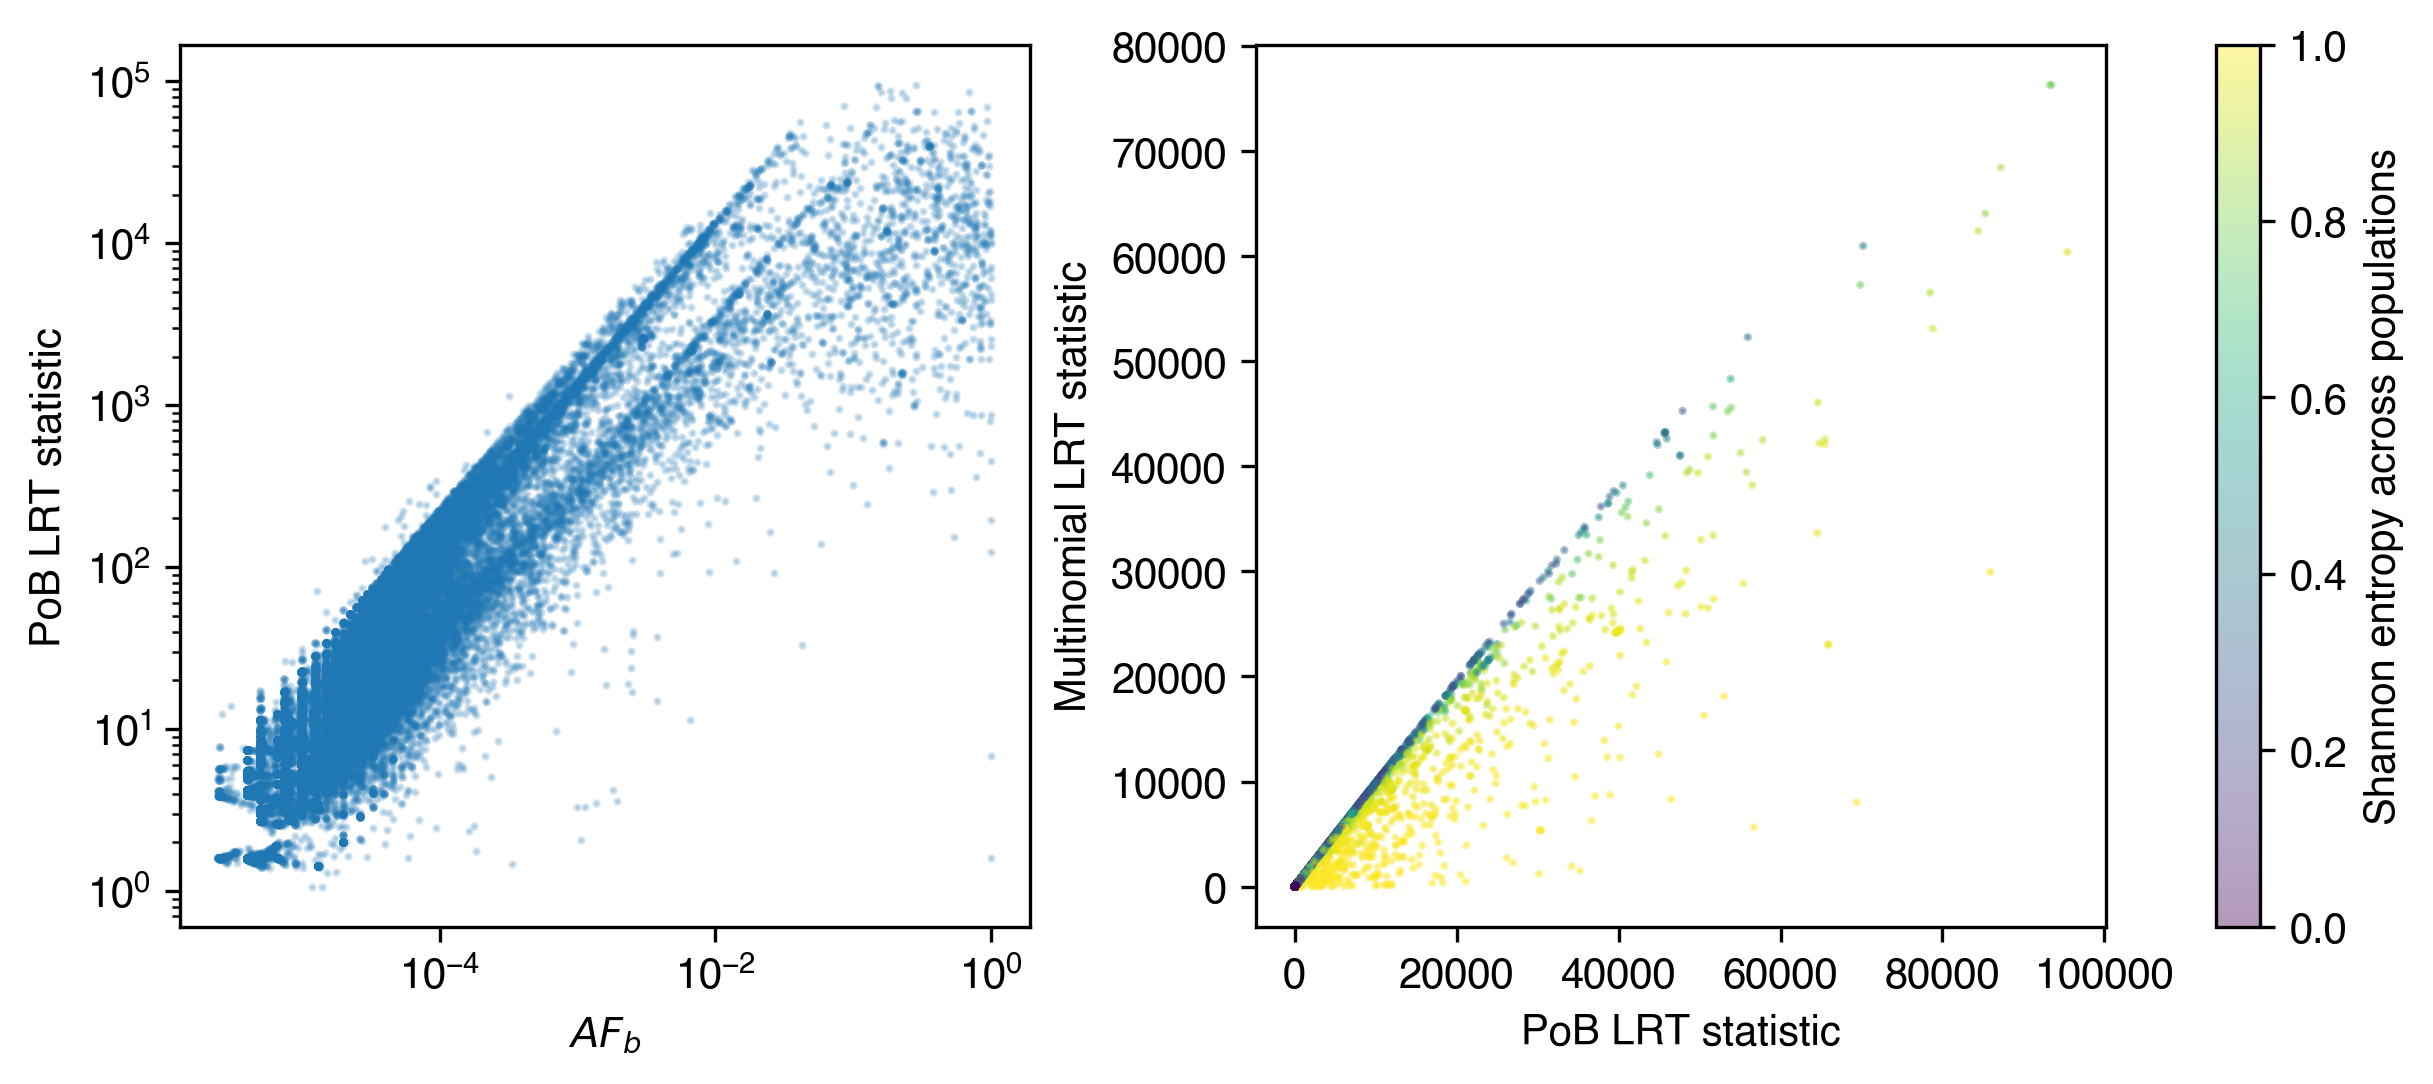

In [142]:
fig, axs = plt.subplots(1,2,figsize=(8,3.5), constrained_layout=True)

ax = axs[0]
ax.scatter((gnomad.both['b:AF-total-all']), 
           (gnomad.both['bin_test']), 
           s=1, color='tab:blue', alpha=0.2)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$AF_b$')
ax.set_ylabel("PoB LRT statistic")


ax = axs[1]
scatter = ax.scatter((gnomad.both['bin_test']), 
           (gnomad.both['mult_test']), 
           s=1, c=gnomad.both['entropy'], alpha=0.4)
ax.set_xlabel('PoB LRT statistic')
ax.set_ylabel("Multinomial LRT statistic")
plt.colorbar(scatter, label='Shannon entropy across populations');
fig.savefig("af_pob_mult.png");

## Bringing in ClinVar

In [144]:
hcm = pd.read_csv('/n/groups/marks/users/ralph/popgen/data/clinvar_disease_tables/hcm.variants.csv', low_memory=False)

In [239]:
def read_clinvar_table(path):
    df = pd.read_csv(path, low_memory=False)
    df['CHROM'] = 'chr' + df['Chromosome']
    df = df.rename(columns={'PositionVCF':'POS', 'Ref':'REF', 'Alt':'ALT'})
    df = df.merge(gnomad.both, on=['CHROM', 'POS', 'REF', 'ALT'], how='left')
    df['_merge'] = df['_merge'].astype('object').fillna('not_in_gnomad').astype('category')
    return df

In [242]:
hcm = read_clinvar_table('/n/groups/marks/users/ralph/popgen/data/clinvar_disease_tables/hcm.variants.csv')
dcm = read_clinvar_table('/n/groups/marks/users/ralph/popgen/data/clinvar_disease_tables/dcm.variants.csv')

In [245]:
dcm.groupby('ClinicalConfidence')['_merge'].value_counts()

ClinicalConfidence               
conflicting         both              3803
                    not_in_gnomad      278
                    exomes             252
                    genomes            228
high                both              6357
                    not_in_gnomad     1620
                    exomes            1157
                    genomes           1007
moderate            not_in_gnomad    10759
                    both              4088
                    exomes            2944
                    genomes           2211
Name: _merge, dtype: int64

In [248]:
hcm.groupby('ClinicalSignificance')['_merge'].value_counts()

ClinicalSignificance                                       
Benign                                        both              974
                                              genomes            83
                                              not_in_gnomad      27
                                              exomes             25
Conflicting interpretations of pathogenicity  both             1345
                                                               ... 
Pathogenic                                    genomes            52
Uncertain significance                        not_in_gnomad    4116
                                              both             2455
                                              exomes           1270
                                              genomes           784
Name: _merge, Length: 24, dtype: int64

In [317]:
fmts_0 = {
    'B/LB': {
        'labels': ['Likely benign', 'Benign'],
        'color': 'tab:blue',
        'histtype': 'bar',
        'alpha': 0.4
    },
    'VUS': {
        'labels': ['Uncertain significance'],
        'color': 'k',
        'histtype': 'step',
        'alpha': 1
    },
    'P/LP': {
        'labels': ['Pathogenic', 'Likely pathogenic'],
        'color': 'tab:red',
        'histtype': 'bar',
        'alpha': 0.6}
    
}

fmts_1 = {
    'B/LB': {
        'labels': ['Likely benign', 'Benign'],
        'confidence': 'moderate',
        'color': 'tab:blue',
        'histtype': 'bar',
        'alpha': 0.4
    },
    'VUS': {
        'labels': ['Uncertain significance'],
        'confidence': 'moderate',
        'color': 'k',
        'histtype': 'step',
        'alpha': 1
    },
    'Conflicting': {
        'labels': ['Conflicting interpretations of pathogenicity'],
        'confidence': 'conflicting',
        'color': 'k',
        'histtype': 'step',
        'alpha': 0.4
    },
    'P/LP': {
        'labels': ['Pathogenic', 'Likely pathogenic'],
        'confidence': 'moderate',
        'color': 'tab:red',
        'histtype': 'bar',
        'alpha': 0.6
    }
}

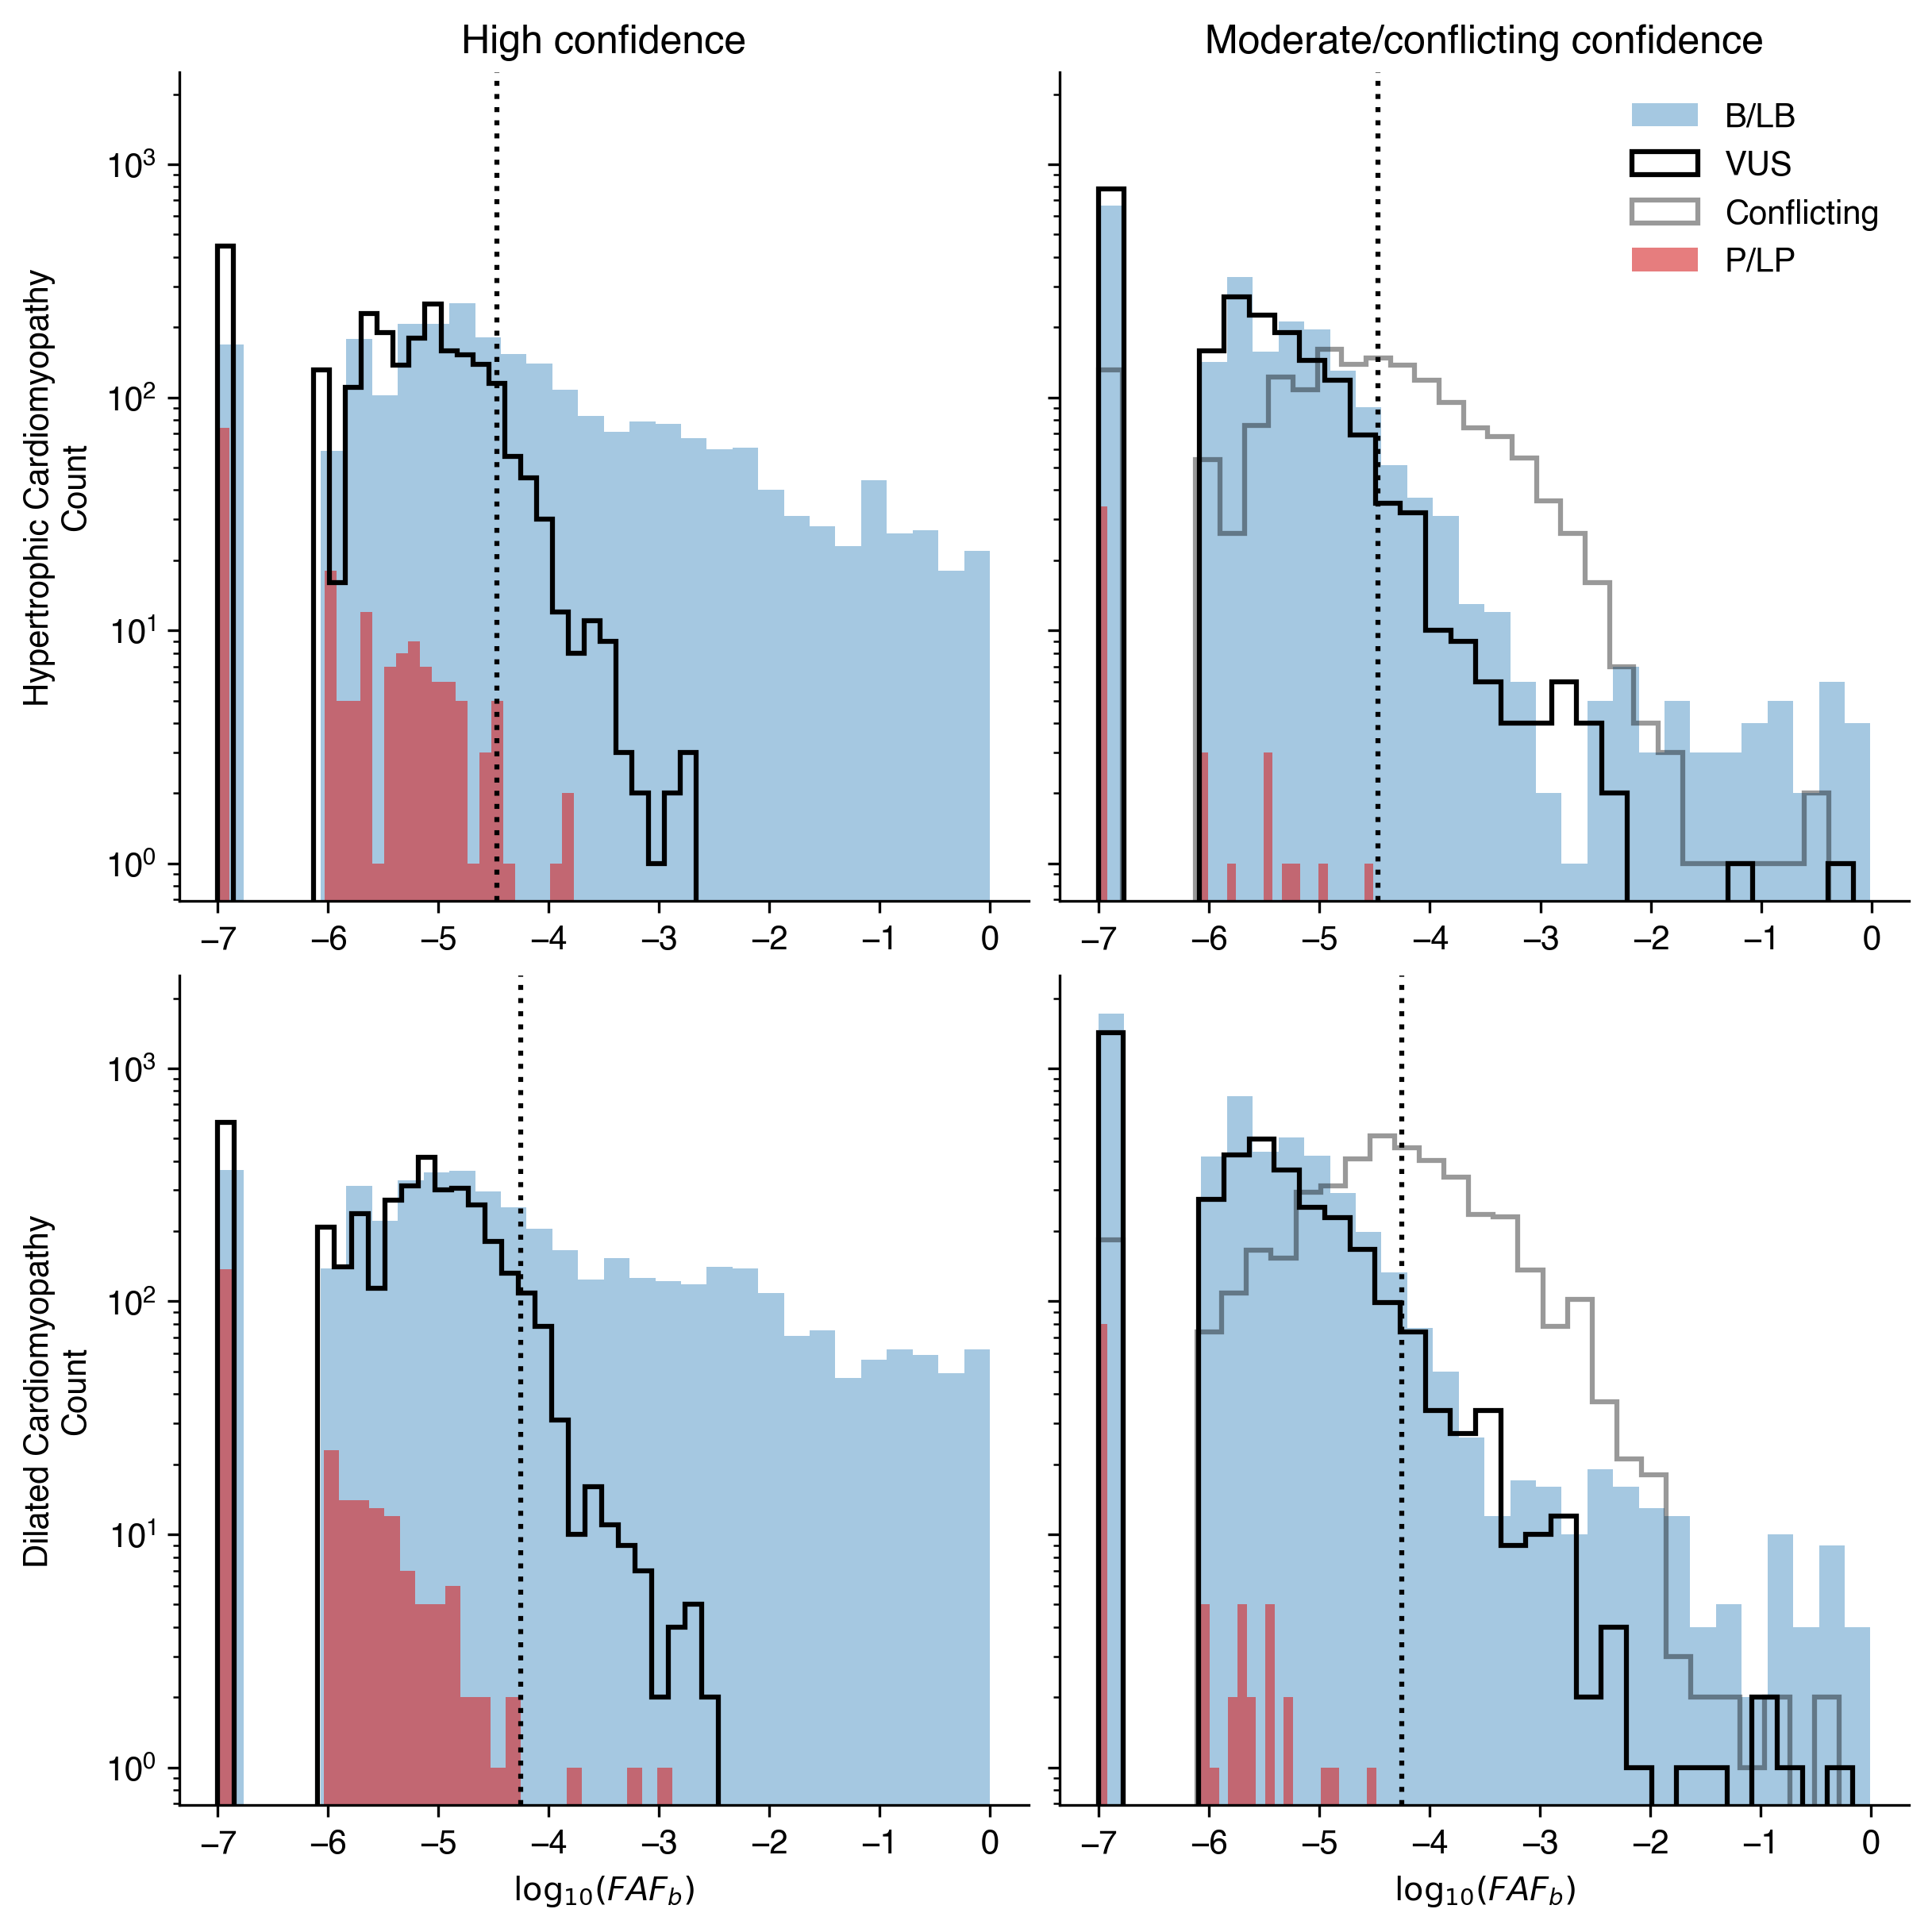

In [318]:
fig, axs = plt.subplots(2,2,figsize=(8,8), constrained_layout=True, sharey=True)

ax = axs[0,0]

for label, fmt in fmts_0.items():
    ax.hist(
        np.log10(hcm[(hcm['ClinicalSignificance'].isin(fmt['labels'])) & 
                     (hcm['ClinicalConfidence'] == 'high')]['b:faf95-total-all'] + 1e-7),
        color=fmt['color'],
        bins=30,
        density=False,
        alpha=fmt['alpha'],
        histtype=fmt['histtype'],
        label=label,
        lw=1.5
    )
ax.set_title('High confidence')
ax.axvline(np.log10(3.4 * 1e-5), ls='dotted', color='k')
ax.set_yscale('log')
ax.set_ylabel('Hypertrophic Cardiomyopathy\nCount')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = axs[0,1]

for label, fmt in fmts_1.items():
    ax.hist(
        np.log10(hcm[(hcm['ClinicalSignificance'].isin(fmt['labels'])) & 
                    (hcm['ClinicalConfidence'] == fmt['confidence'])]['b:faf95-total-all'] + 1e-7),
        color=fmt['color'],
        bins=30,
        density=False,
        alpha=fmt['alpha'],
        histtype=fmt['histtype'],
        label=label,
        lw=1.5
    )
ax.legend(frameon=False)
ax.set_title('Moderate/conflicting confidence')
ax.set_yscale('log')
ax.axvline(np.log10(3.4 * 1e-5), ls='dotted', color='k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax = axs[1,0]

for label, fmt in fmts_0.items():
    ax.hist(
        np.log10(dcm[(dcm['ClinicalSignificance'].isin(fmt['labels'])) & 
                     (dcm['ClinicalConfidence'] == 'high')]['b:faf95-total-all'] + 1e-7),
        color=fmt['color'],
        bins=30,
        density=False,
        alpha=fmt['alpha'],
        histtype=fmt['histtype'],
        label=label,
        lw=1.5
    )
ax.axvline(np.log10(5.6 * 1e-5), ls='dotted', color='k')
ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}(FAF_b)$')
ax.set_ylabel('Dilated Cardiomyopathy\nCount')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = axs[1,1]

for label, fmt in fmts_1.items():
    ax.hist(
        np.log10(dcm[(dcm['ClinicalSignificance'].isin(fmt['labels'])) & 
                    (dcm['ClinicalConfidence'] == fmt['confidence'])]['b:faf95-total-all'] + 1e-7),
        color=fmt['color'],
        bins=30,
        density=False,
        alpha=fmt['alpha'],
        histtype=fmt['histtype'],
        label=label,
        lw=1.5
    )
ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}(FAF_b)$')
ax.axvline(np.log10(5.6 * 1e-5), ls='dotted', color='k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig("faf_vs_clinvar_whiffin_bound.png");

In [319]:
fmts_0 = {
    'B/LB': {
        'labels': ['Likely benign', 'Benign'],
        'color': 'tab:blue',
        'alpha': 0.7
    },
    'VUS': {
        'labels': ['Uncertain significance'],
        'color': 'k',
        'alpha': 0.5
    },
    'P/LP': {
        'labels': ['Pathogenic', 'Likely pathogenic'],
        'color': 'tab:red',
        'alpha': 1}    
}


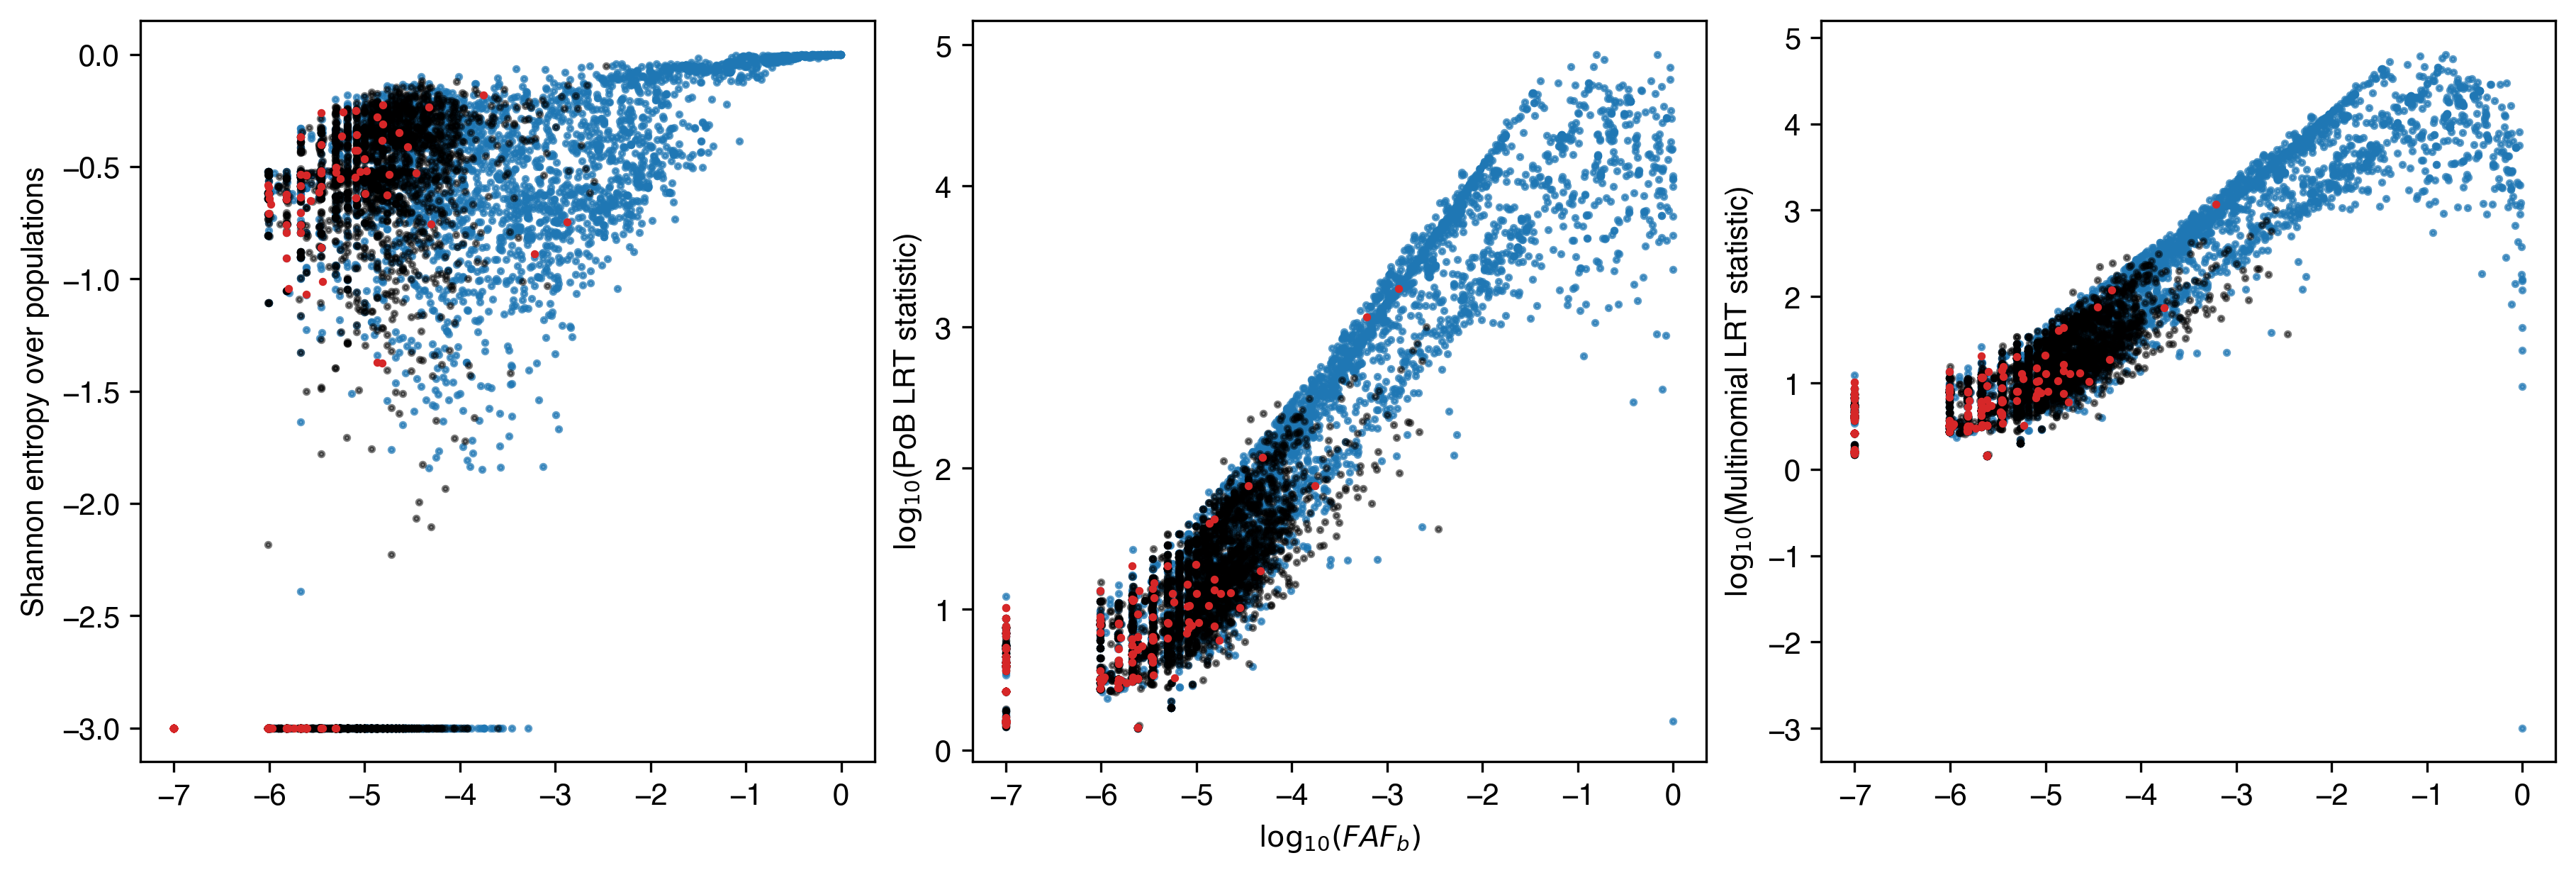

In [322]:
fig, axs = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)

ax = axs[0]
for label, fmt in fmts_0.items():
    df = dcm[(dcm['ClinicalSignificance'].isin(fmt['labels'])) & 
             (dcm['ClinicalConfidence'] == 'high')]
    ax.scatter(
        np.log10(df['b:faf95-total-all'] + 1e-7),
        np.log10(df['entropy'] + 1e-3),
        color=fmt['color'],
        alpha=fmt['alpha'],
        label=label,
        s=3
    )
ax.set_xlabel('')
ax.set_ylabel('Shannon entropy over populations')

ax = axs[1]
for label, fmt in fmts_0.items():
    df = dcm[(dcm['ClinicalSignificance'].isin(fmt['labels'])) & 
             (dcm['ClinicalConfidence'] == 'high')]
    ax.scatter(
        np.log10(df['b:faf95-total-all'] + 1e-7),
        np.log10(df['bin_test'] + 1e-3),
        color=fmt['color'],
        alpha=fmt['alpha'],
        label=label,
        s=3
    )
ax.set_xlabel(r'$\log_{10}(FAF_b)$')
ax.set_ylabel(r'$\log_{10}$(PoB LRT statistic)')

ax = axs[2]
for label, fmt in fmts_0.items():
    df = dcm[(dcm['ClinicalSignificance'].isin(fmt['labels'])) & 
             (dcm['ClinicalConfidence'] == 'high')]
    ax.scatter(
        np.log10(df['b:faf95-total-all'] + 1e-7),
        np.log10(df['mult_test'] + 1e-3),
        color=fmt['color'],
        alpha=fmt['alpha'],
        label=label,
        s=3
    )
ax.set_xlabel('')
ax.set_ylabel(r'$\log_{10}$(Multinomial LRT statistic)');
fig.savefig("faf_vs_clustering.png");